In [1]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import simplstyles
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend

from compare_variance_residual.simulation.residual_method import residual_method
from compare_variance_residual.simulation.dataset import generate_dataset
from compare_variance_residual.simulation.variance_partitioning import variance_partitioning

In [2]:
plt.style.use('nord-light-talk')

In [3]:
def get_path():
    path = os.path.join("results", "varying noise")
    os.makedirs(path, exist_ok=True)
    return path

In [4]:
def get_experiments():
    path = get_path()
    experiments = []
    for file in os.listdir(path):
        if file.endswith(".csv"):
            variable = file.split("_")[1].split(".csv")[0]
            # parse variable
            noise = float(variable)
            experiments.append(noise)
    return experiments

In [5]:
def save_scores(noise_levels, n_samples=20000, n_samples_train=10000):
    path = get_path()
    for noise_target in noise_levels:
        print(noise_target)
        csv_path = os.path.join(path, f"scores_{noise_target}.csv")
        scores = pd.DataFrame()
        if os.path.exists(csv_path):
            print("skipping, already exists")
            continue
        Xs, Y = generate_dataset(n_samples=n_samples, noise_target=noise_target, noise_features=0.0)
        print(Xs)
        print("data generated")
        x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score = variance_partitioning(
            Xs, Y, n_samples_train)
        scores["x1_score"] = x1_score
        scores["x2_score"] = x2_score
        scores["vp_joint_score"] = joint_score
        scores["vp_shared_score"] = x1_and_x2_score
        scores["vp_x1_unique_score"] = vp_x1_unique_score
        scores["vp_x2_unique_score"] = vp_x2_unique_score
        print(scores.head())

        x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score = residual_method(
            Xs, Y, n_samples_train)
        scores["rm_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_score, np.full(len(rm_x1_unique_score) - len(x2_to_x1_score), np.nan)])
        scores["rm_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_score, np.full(len(rm_x1_unique_score) - len(x1_to_x2_score), np.nan)])
        scores["rm_x1_unique_score"] = rm_x1_unique_score
        scores["rm_x2_unique_score"] = rm_x2_unique_score
        print(scores.head())

        # ridge residual
        x2_to_x1_ridge_score, x1_to_x2_ridge_score, rm_ridge_x1_unique_score, rm_ridge_x2_unique_score = residual_method(
            Xs, Y, n_samples_train, use_ols=False)
        scores["rm_ridge_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_ridge_score, np.full(len(rm_ridge_x1_unique_score) - len(x2_to_x1_ridge_score), np.nan)])
        scores["rm_ridge_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_ridge_score, np.full(len(rm_ridge_x1_unique_score) - len(x1_to_x2_ridge_score), np.nan)])
        scores["rm_ridge_x1_unique_score"] = rm_ridge_x1_unique_score
        scores["rm_ridge_x2_unique_score"] = rm_ridge_x2_unique_score
        del Xs, Y
        print(scores.head())
        scores.to_csv(csv_path, index=False)

# Save scores for varying noise levels

In [6]:
backend = set_backend("torch_cuda")
warnings.filterwarnings("ignore")
random.seed(42)
plt.style.use('nord-light-talk')

In [7]:
nstep = 21
noise_levels = np.linspace(0, 1, nstep)
noise_levels

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [8]:
save_scores(noise_levels)

0.0
skipping, already exists
0.05
skipping, already exists
0.1
skipping, already exists
0.15000000000000002
skipping, already exists
0.2
skipping, already exists
0.25
skipping, already exists
0.30000000000000004
skipping, already exists
0.35000000000000003
skipping, already exists
0.4
skipping, already exists
0.45
skipping, already exists
0.5
skipping, already exists
0.55
skipping, already exists
0.6000000000000001
skipping, already exists
0.65
skipping, already exists
0.7000000000000001
skipping, already exists
0.75
skipping, already exists
0.8
skipping, already exists
0.8500000000000001
skipping, already exists
0.9
skipping, already exists
0.9500000000000001
skipping, already exists
1.0
skipping, already exists


# Plot scores

In [9]:
vp = pd.DataFrame()
rm = pd.DataFrame()
rm_ridge = pd.DataFrame()

all_levels = get_experiments()
print(all_levels)
for i, noise_level in enumerate(all_levels):
    scores = pd.read_csv(os.path.join(get_path(), f"scores_{noise_level}.csv"))
    vp_x1_unique_predicted = scores['vp_x1_unique_score']
    vp_scores = pd.DataFrame({
        'noise_target': [noise_level] * len(vp_x1_unique_predicted),
        'vp_x1_unique_score': vp_x1_unique_predicted,
    }, index=range(len(vp_x1_unique_predicted)))

    rm_x1_unique_score = scores['rm_x1_unique_score']
    rm_scores = pd.DataFrame({
        'noise_target': [noise_level] * len(vp_x1_unique_predicted),
        'rm_x1_unique_score': rm_x1_unique_score,
    }, index=range(len(vp_x1_unique_predicted)))

    rm_ridge_x1_unique_score = scores['rm_ridge_x1_unique_score']
    rm_ridge_scores = pd.DataFrame({
        'noise_target': [noise_level] * len(vp_x1_unique_predicted),
        'rm_ridge_x1_unique_score': rm_ridge_x1_unique_score,
    }, index=range(len(vp_x1_unique_predicted)))

    vp = pd.concat([vp, vp_scores], ignore_index=True)
    rm = pd.concat([rm, rm_scores], ignore_index=True)
    rm_ridge = pd.concat([rm_ridge, rm_ridge_scores], ignore_index=True)
rm.head()

[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0]


,noise_target,rm_x1_unique_score
0,0.0,0.319714
1,0.0,0.331448
2,0.0,0.329596
3,0.0,0.312355
4,0.0,0.300407


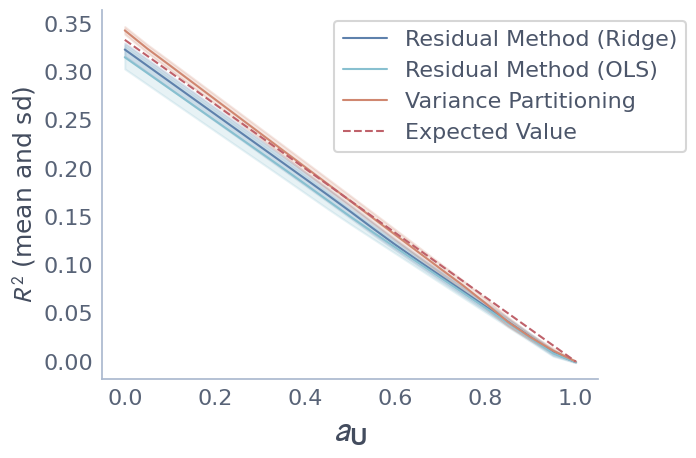

In [35]:
# fig, ax = plt.subplots(figsize=(7, 4))
sns.lineplot(data=rm_ridge, x='noise_target', y='rm_ridge_x1_unique_score', label='Residual Method (Ridge)',
             errorbar='sd')
sns.lineplot(data=rm, x='noise_target', y='rm_x1_unique_score', label='Residual Method (OLS)', errorbar='sd')
sns.lineplot(data=vp, x='noise_target', y='vp_x1_unique_score', label='Variance Partitioning', errorbar='sd')
expected_values = 1 / 3 * (1 - noise_levels)
plt.plot(noise_levels, expected_values, linestyle='--', label='Expected Value')
plt.xlabel(r"$a_\mathbf{U}$", fontsize=26)
# plt.xticks(noise_levels, labels=[f"{noise:.1f}" for noise in noise_levels])
plt.ylabel(r"$R^2$ (mean and sd)")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', frameon=True)